<a href="https://colab.research.google.com/github/anoopmoothedath/Mask_RCNN/blob/hail/hail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install q keras==2.1.0
#import keras
#keras.__version__

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/matterport/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [0]:
############################################################
#  Configurations
############################################################


class HailConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "hail"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 + 1  # Background + hail + hand

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


In [0]:
############################################################
#  Dataset
############################################################

class HailDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        

        # Add classes. We have only one class to add.
        self.add_class("hail", 1, "hail")
        self.add_class("hand",2, "hand")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "hails.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                ids = [r['region_attributes'] for r in a['regions'].values()]   ###--------------> Changed
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 
                ids = [r['region_attributes'] for r in a['regions']]   ###--------------> Changed
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            ##print(ids) ----> check if it's working
            ##assert testing in ['abcd']   -----> to generate exception

            self.add_image(
                "hail",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,region_attributes=ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "hail":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        ids=np.zeros(len(info["polygons"]),
                        dtype=np.uint32)

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            ids[i] = int(info['region_attributes'][i]['object'])##----------> changed
            
        
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)##----------> original
        return mask.astype(np.bool), ids##-------> changed

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "hail":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = HailDataset()
    dataset_train.load_balloon("/content/drive/My Drive/Mask_RCNN_Hail/Combined", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = HailDataset()
    dataset_val.load_balloon("/content/drive/My Drive/Mask_RCNN_Hail/Combined" , "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,layers='heads')
                #layers='heads')


In [7]:
############################################################
#  Training
############################################################


# Configurations
    args="train"
    if args == "train":
        config = HailConfig()
    else:
        class InferenceConfig(HailConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
    # Create model
    if args == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=os.path.join(ROOT_DIR, "logs"))
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=os.path.join(ROOT_DIR, "logs"))

    weights="something else"
    # Select weights file to load
    if weights == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif weights == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif weights == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        #weights_path = "/content/drive/My Drive/Mask_RCNN_Hail/hail_weights.h5"
        weights_path = "/content/drive/My Drive/Mask_RCNN_Hail/hail_weights_combined.h5"

    # Load weights
    print("Loading weights ", weights_path)
    if weights == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train or evaluate
    if args == "train":
        train(model)
    elif args == "splash": 
        detect_and_color_splash(model, image_path=args.image,
                                video_path=args.video)
    else:
        print("'{}' is not recognized. "
              "Use 'train' or 'splash'".format(args.command))







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Loading weights  /content/drive/My Drive/Mask_RCNN_Hail/hail_weights_combined.h5






Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/hail20200512T1408/mask_rcnn_hail_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistribut

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
4/5 [=======================>......] - ETA: 6s - loss: 1.1249 - rpn_class_loss: 0.1365 - rpn_bbox_loss: 0.3925 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.2364 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



5/5 [==============================] - 142s 28s/step - loss: 1.3141 - rpn_class_loss: 0.1759 - rpn_bbox_loss: 0.4217 - mrcnn_class_loss: 0.2012 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2855 - val_loss: 1.1866 - val_rpn_class_loss: 0.0530 - val_rpn_bbox_loss: 0.4085 - val_mrcnn_class_loss: 0.1314 - val_mrcnn_bbox_loss: 0.3345 - val_mrcnn_mask_loss: 0.2593
Epoch 2/20
5/5 [==============================] - 36s 7s/step - loss: 0.8446 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.2521 - val_loss: 1.1493 - val_rpn_class_loss: 0.0542 - val_rpn_bbox_loss: 0.4083 - val_mrcnn_class_loss: 0.1286 - val_mrcnn_bbox_loss: 0.3089 - val_mrcnn_mask_loss: 0.2493
Epoch 3/20
5/5 [==============================] - 36s 7s/step - loss: 1.1921 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.3770 - mrcnn_class_loss: 0.1854 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.2999 - val_loss: 1.1973 - val_rpn_class_loss: 0.0470 - val_rpn_b

In [0]:
weights_path="/content/drive/My Drive/Mask_RCNN_Hail/hail_weights_combined.h5"
model.keras_model.save_weights(weights_path)

In [10]:
class InferenceConfig(HailConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [11]:
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=os.path.join(ROOT_DIR, "logs"))
model.load_weights(weights_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.


In [0]:
class_names = ['BG','hail','hand']

Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


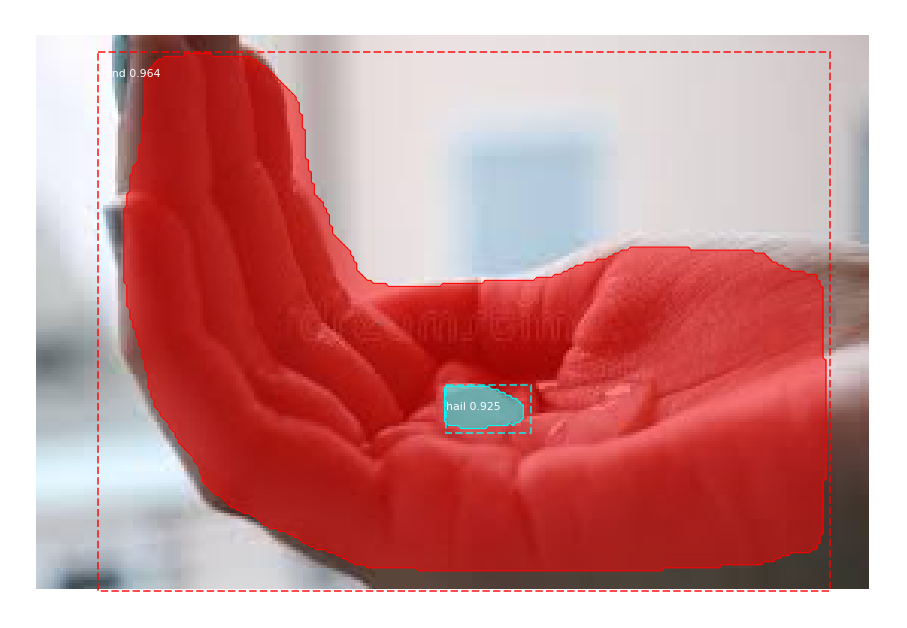

In [13]:
import random
from mrcnn import visualize

IMAGE_DIR="/content/drive/My Drive/Mask_RCNN_Hail/Combined/test/"

# Load a random image from the images folder
file_names =next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [14]:
####----------------Testing-----------------------####

dataset_dir="/content/drive/My Drive/Mask_RCNN_Hail/Combined/train"
annotations = json.load(open(os.path.join(dataset_dir, "hails.json")))
annotations = list(annotations.values())  # don't need the dict keys

# The VIA tool saves images in the JSON even if they don't have any
# annotations. Skip unannotated images.
annotations = [a for a in annotations if a['regions']]

for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            print(image_path)
            print(polygons)

/content/drive/My Drive/Mask_RCNN_Hail/Combined/train/2Q__ (1).jpg
[{'name': 'polygon', 'all_points_x': [0, 22, 52, 60, 62, 54, 42, 31, 31, 21, 21, 39, 81, 100, 114, 122, 125, 123, 111, 111, 123, 135, 143, 151, 150, 136, 148, 153, 160, 161, 152, 157, 158, 141, 129, 115, 101, 96, 82, 74, 50, 7, 0], 'all_points_y': [37, 27, 18, 23, 33, 44, 53, 56, 56, 63, 67, 58, 28, 16, 12, 15, 20, 24, 34, 37, 28, 21, 20, 26, 31, 44, 36, 36, 40, 45, 56, 61, 64, 86, 98, 117, 134, 140, 152, 162, 176, 133, 121]}, {'name': 'polygon', 'all_points_x': [59, 59, 66, 69, 69, 65, 67, 64, 61, 53, 49, 52, 51, 55], 'all_points_y': [94, 93, 94, 100, 103, 104, 106, 109, 111, 112, 110, 105, 96, 95]}, {'name': 'polygon', 'all_points_x': [93, 102, 102, 96, 89, 88, 89], 'all_points_y': [87, 88, 94, 98, 97, 92, 88]}, {'name': 'polygon', 'all_points_x': [48, 47, 57, 58, 64, 64, 63, 63, 60, 57], 'all_points_y': [78, 89, 93, 93, 89, 89, 83, 82, 79, 76]}]
/content/drive/My Drive/Mask_RCNN_Hail/Combined/train/2Q__ (2).jpg
[{'na